In [1]:
#Importing all the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from numpy.random import seed
from itertools import chain
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional
from tensorflow.keras.utils import to_categorical


plt.style.use('seaborn')

In [2]:
# getting the data
file = r'C:\Users\Sanket\Desktop\TEST.csv'
data = pd.read_csv(file, encoding = "latin1")

In [3]:
data.head()

,Sentence #,Word,Tag
0,Sentence 1,Andhra,B-loc
1,NaN,High Court,B-court
2,NaN,.,O
3,Sentence 2,Channala,B-per
4,NaN,Ramachandra,B-per


In [4]:
#Filling the NAN values
data = data.fillna(method = 'ffill')

In [5]:
#Making a list of words
words = list(set(data["Word"].values))

#Adding End Padding
words.append("ENDPAD")
num_words = len(words)

print(f"Total number of unique words in dataset: {num_words}")
print (words)

Total number of unique words in dataset: 1520
['because', 'submit', 'respondent,', 'us', '(34', '(11', 'through', 'registered', 'On', 'insofar', 'Educational', 'nominal', 'curial', 'resorted', 'declaring', 'effect', 'Ranga', '27(a)', 'guidelines,', 'wholly', 'seats/', 'points', 'Caste,', '2126,', 'submits', 'class,', 'vs', 'Pleadings', 'vires', 'coming', 'I308', 'genuine', 'Dealing', 'ascertained', 'find', 'due', 'principles', 'rational', 'amendment', 'Advocate', 'powers', 'kept', 'Ella', 'choosing', 'Municipal', 'excluded', 'passion', 'By', 'notifications', 'These', 'reservations', 'General', '1720', 'considering', 'decided', 'apprehension', '18-19%', 'providing', "'urban", 'picture,', 'R', '9%', 'Chairpersons', '(draft)', 'Reddy,', 'given', 'first', 'Krishna', '243-U(3)(a),', 'District', '52%', '(Elecs', 'showing', 'drawn', 'area', 'Advocates', '2081,', 'Caste', 'inserted', 'High Court', '41', 'Courts,', 'provides', 'objections', 'offices', 'mechanism', 'Ramanaiah,', 'He', 'Mayor,', 

In [6]:
#Making list of tags
tags = list(set(data["Tag"].values))
num_tags = len(tags)
num_tags
print("List of tags: " + ', '.join([tag for tag in tags]))
print(f"Total Number of tags {num_tags}")

List of tags: year, B-percent, date, B-dec, B-loc, B-acq, B-per, B-act, O, B-order, B-org, o, B-court, B-obj, B-judge
Total Number of tags 15


In [7]:
#Grouping Words and tags 

class Get_sentence(object):
    def __init__(self,data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s:[(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                    s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [8]:
getter = Get_sentence(data)
sentence = getter.sentences
sentence[10]

[('As', 'O'),
 ('the', 'O'),
 ('Office', 'O'),
 ('of', 'O'),
 ('Chairperson', 'O'),
 ('of', 'O'),
 ('Tadepalligudem', 'B-loc'),
 ('was', 'O'),
 ('reserved', 'O'),
 ('for', 'O'),
 ('Woman', 'O'),
 ('(General)', 'O'),
 ('1995', 'O'),
 ('elections,', 'O'),
 ('this', 'O'),
 ('time', 'O'),
 ('same', 'O'),
 ('was', 'O'),
 ('reserved', 'O'),
 ('for', 'O'),
 ('BCs', 'O')]

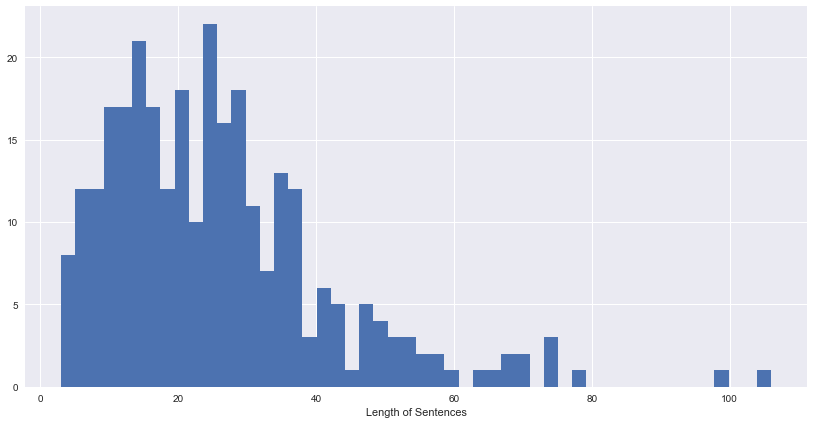

In [9]:
#Mapping length of sentences
plt.figure(figsize=(14,7))
plt.hist([len(s) for s in sentence],bins = 50)
plt.xlabel("Length of Sentences")
plt.show()

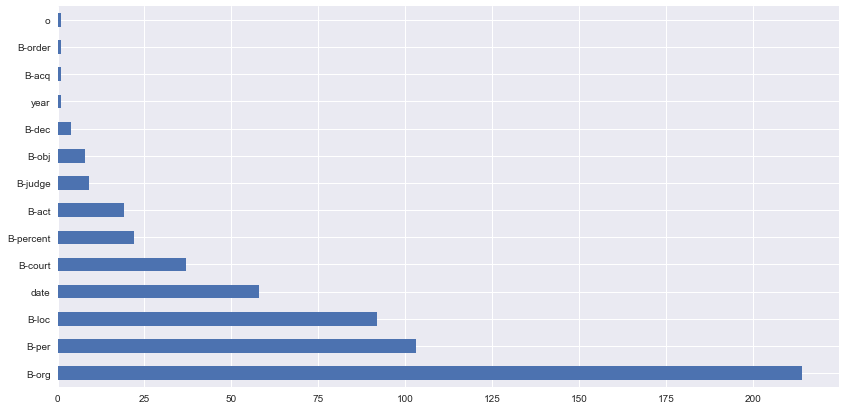

In [10]:
#Mapping no. of tags in the whole corpus
plt.figure(figsize=(14, 7))
data.Tag[data.Tag != 'O']\
    .value_counts()\
    .plot\
    .barh();

In [11]:
# Indexing words and tags
word_idx = {w : i + 1 for i ,w in enumerate(words)}
tag_idx =  {t : i for i ,t in enumerate(tags)}

#print (word_idx)
#print (tag_idx)

In [12]:
tag_idx

{'year': 0,
 'B-percent': 1,
 'date': 2,
 'B-dec': 3,
 'B-loc': 4,
 'B-acq': 5,
 'B-per': 6,
 'B-act': 7,
 'O': 8,
 'B-order': 9,
 'B-org': 10,
 'o': 11,
 'B-court': 12,
 'B-obj': 13,
 'B-judge': 14}

In [13]:
#Padding the sequences
#Changing the list of words into 2D numpy arrays.
max_len = 50
X = [[word_idx[w[0]] for w in s] for s in sentence]
X = pad_sequences(maxlen = max_len, sequences = X, padding = 'post', value = num_words - 1)

y = [[tag_idx[w[1]] for w in s] for s in sentence]
y = pad_sequences(maxlen = max_len, sequences = y, padding = 'post', value = tag_idx['O'])
y = [to_categorical(i, num_classes = num_tags) for i in  y]

print(X)

[[ 972  571  331 ... 1519 1519 1519]
 [ 735  222 1386 ...  987  460  844]
 [ 799   80 1276 ... 1519 1519 1519]
 ...
 [1292  106 1385 ... 1519 1519 1519]
 [1292 1458 1281 ... 1519 1519 1519]
 [   9  873  333 ... 1519 1519 1519]]


In [14]:
#Spling training and testing data
x_train,x_test,y_train,y_test = train_test_split(X, y,test_size = 0.1, random_state = 1)


In [15]:
#Creating the model
#Instantiating a Keras tensor.
input_word = Input(shape = (max_len,))
model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units = 100,return_sequences = True, recurrent_dropout = 0.1))(model)
out = TimeDistributed(Dense(num_tags,activation = 'softmax'))(model)
model = Model(input_word,out)

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            76000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 15)           3015      
 ibuted)                                                         
                                                             

In [16]:
#plot_model(model, show_shapes = True)


In [17]:
#Training the model 
model.fit(x_train, np.array(y_train), batch_size = 16, verbose = 2, epochs = 50, validation_split = 0.2)

Epoch 1/50
13/13 - 8s - loss: 1.9631 - accuracy: 0.8919 - val_loss: 0.3271 - val_accuracy: 0.9536 - 8s/epoch - 626ms/step
Epoch 2/50
13/13 - 1s - loss: 0.2778 - accuracy: 0.9678 - val_loss: 0.4017 - val_accuracy: 0.9536 - 1s/epoch - 79ms/step
Epoch 3/50
13/13 - 1s - loss: 0.2571 - accuracy: 0.9678 - val_loss: 0.3057 - val_accuracy: 0.9536 - 951ms/epoch - 73ms/step
Epoch 4/50
13/13 - 1s - loss: 0.2244 - accuracy: 0.9678 - val_loss: 0.2908 - val_accuracy: 0.9536 - 963ms/epoch - 74ms/step
Epoch 5/50
13/13 - 1s - loss: 0.2128 - accuracy: 0.9678 - val_loss: 0.2819 - val_accuracy: 0.9536 - 884ms/epoch - 68ms/step
Epoch 6/50
13/13 - 1s - loss: 0.2016 - accuracy: 0.9678 - val_loss: 0.2629 - val_accuracy: 0.9536 - 1s/epoch - 82ms/step
Epoch 7/50
13/13 - 1s - loss: 0.1870 - accuracy: 0.9678 - val_loss: 0.2528 - val_accuracy: 0.9536 - 802ms/epoch - 62ms/step
Epoch 8/50
13/13 - 1s - loss: 0.1777 - accuracy: 0.9678 - val_loss: 0.2532 - val_accuracy: 0.9536 - 835ms/epoch - 64ms/step
Epoch 9/50
13/13

In [22]:
#Evaluating the model
model.evaluate(x_test, np.array(y_test))


1/1 [==============================] - 0s 48ms/step - loss: 0.1701 - accuracy: 0.9731


[0.17006784677505493, 0.9731034636497498]

In [29]:
#Testing the model 

rand_sent = np.random.randint(0, x_test.shape[0]) # get a random sentense
p = model.predict(np.array([x_test[rand_sent]]))
p = np.argmax(p, axis = -1)

y_true = np.argmax(np.array(y_test), axis = -1)[rand_sent] # get actual tags for random sentense

print("{:20}{:20}\t{}\n".format("Word", "True", "Pred"))
print("-" * 55)

for (w, t, pred) in zip(x_test[rand_sent], y_true, p[0]):
    print("{:20}{:20}\t{}".format(words[w - 1], tags[t], tags[pred]))

Word                True                	Pred

-------------------------------------------------------
The                 O                   	O
method              O                   	O
taking              O                   	O
lottery             O                   	O
also                O                   	O
contrary            O                   	O
ratio               O                   	O
Full                O                   	O
Bench               O                   	O
of                  O                   	O
Court               B-court             	B-court
Fakruddin           B-per               	B-per
case                O                   	O
(supra)             O                   	O
.                   O                   	O
elections           O                   	O
elections           O                   	O
elections           O                   	O
elections           O                   	O
elections           O                   	O
elections           O      

# #Future Scope

In [20]:
def create_test_input_from_text(text):
    word_list = text.split(" ")
    x_new = []
    for word in word_list:
        x_new.append(word_idx[word])
        
    p = model.predict(np.array([x_new]))
    p = np.argmax(p, axis = -1)
    print("{:20}\t{}\n".format("Word", "Prediction"))
    print("-" * 35)

    for (w, pred) in zip(range(len(x_new)), p[0]):
        print("{:20}\t{}".format(word_list[w], tags[pred]))

In [21]:
test_inputs = "The petitioner is a Association. It is registered and established under the Societies Registration Act, 1860 with the object of safeguarding the rights of the persons belonging to Scheduled Tribes and espouse their cause in regard to their employment. Complaining fraud and misrepresentation the association filed this writ petition praying for a writ of or in the nature of Mandamus, holding that the appointment of the first respondent herein to the post of District and Sessions Judge, is void, unconstitutional, and also for a prayer to set aside the same. "
create_test_input_from_text(test_inputs)

KeyError: 'Association.'